### FInding the largest tumour area

In [1]:
import os
import numpy as np
import nibabel as nib
from skimage.measure import label, regionprops

directories = {
    "HCC": "/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC",
    "ICC": "/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC",
    "MCRC": "/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC",
}

def get_max_tumor_slice_and_size(directory):
    max_slice = 0
    max_slice_index = None
    max_slice_size = (0, 0)  # x, y size of largest region's bounding box

    for filename in os.listdir(directory):
        if filename.endswith('.nii') or filename.endswith('.nii.gz'):
            filepath = os.path.join(directory, filename)
            img = nib.load(filepath)
            data = img.get_fdata()
            
            # Assuming the tumor is labeled as 2
            tumor_pixels = (data == 2)

            for z in range(data.shape[2]):
                slice_data = tumor_pixels[:,:,z]
                
                # Identify individual regions of connected tumor pixels
                labeled_image, num_labels = label(slice_data, connectivity=2, return_num=True)
                regions = regionprops(labeled_image)
                
                # Sum up the areas of all detected regions in the slice
                total_area = sum([r.area for r in regions])
                
                if total_area > max_slice:
                    max_slice = total_area
                    max_slice_index = (filename, z)
                    
                    # Find the region with the largest area
                    largest_region = max(regions, key=lambda r: r.area)
                    
                    # Get the x, y size of the bounding box of the largest region
                    minr, minc, maxr, maxc = largest_region.bbox
                    max_slice_size = (maxc - minc, maxr - minr)

    return max_slice_index, max_slice, max_slice_size

for tumor_type, directory in directories.items():
    max_slice_info, max_slice_value, max_slice_size = get_max_tumor_slice_and_size(directory)
    print(f"For {tumor_type}, the slice with the most tumor area is in file {max_slice_info[0]} at slice index {max_slice_info[1]}, with a total area of {max_slice_value} pixels. The size of the largest tumor region in this slice is {max_slice_size}.")

For HCC, the slice with the most tumor area is in file 156-hcc_volume.nii at slice index 24, with a total area of 28732.0 pixels. The size of the largest tumor region in this slice is (233, 180).
For ICC, the slice with the most tumor area is in file 088_ICCrecurrence_volume.nii at slice index 65, with a total area of 25372.0 pixels. The size of the largest tumor region in this slice is (206, 168).
For MCRC, the slice with the most tumor area is in file mcrc_045.nii at slice index 17, with a total area of 18649.0 pixels. The size of the largest tumor region in this slice is (154, 172).


### Extracting Largest Dillated Tumour 2D Axial Slices

In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from skimage.measure import label as skimage_label, regionprops
from tqdm import tqdm
import cv2
import re
import heapq

# Define the directories containing the images and labels for each tumor type
image_paths = {
    'HCC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/HCC',
    'ICC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/ICC',
    'MCRC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/images/MCRC'
}

label_paths = {
    'HCC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/HCC',
    'ICC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/ICC',
    'MCRC': '/mnt/largedrive0/rmojtahedi/liver_classifcation/labels/MCRC'
}

# Define the directory where the tumor slices will be saved
output_dir = '/mnt/largedrive0/rmojtahedi/minhaj/extracted_tumours'

# Modify the output_dirs to save directly under tumor types
output_dirs = {
    'HCC': os.path.join(output_dir, 'HCC'),
    'ICC': os.path.join(output_dir, 'ICC'),
    'MCRC': os.path.join(output_dir, 'MCRC')
}

# Define the maximum axial slice dimensions for each tumor type
max_axial_slice_dimensions = {
    'HCC': (233, 180),
    'ICC': (206, 168),
    'MCRC': (154, 172)
}

def apply_windowing(image, window_center, window_width):
    # Define window limits
    lower_limit = window_center - (window_width / 2)
    upper_limit = window_center + (window_width / 2)
    windowed_image = np.clip(image, lower_limit, upper_limit)
    
    # Normalize the windowed image to the range [0, 255]
    return ((windowed_image - lower_limit) / window_width * 255).astype(np.uint8)

def dilate_label(label_slice, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_label = cv2.dilate(label_slice.astype(np.uint8), kernel, iterations=1)
    return dilated_label

def get_largest_tumor_slice(label_arr, min_area=50):
    labeled_tumors = skimage_label(label_arr == 2)
    tumor_regions = regionprops(labeled_tumors)
    num_slices = label_arr.shape[2]

    tumor_areas = [(z, np.sum(np.where(label_arr[:, :, z] == 2, 1, 0))) for z in range(num_slices) if np.sum(np.where(label_arr[:, :, z] == 2, 1, 0)) >= min_area]
    
    # Return only the single largest tumor slice
    largest_tumor_slice = max(tumor_areas, key=lambda x: x[1], default=None)
    return largest_tumor_slice[0] if largest_tumor_slice else None

def crop_image(ct_slice, label_slice, tumor_type):
    tumor_mask = label_slice == 2
    non_zero_indices = np.where(tumor_mask)

    if len(non_zero_indices[0]) == 0:
        return np.zeros_like(ct_slice), np.zeros_like(label_slice)

    tumor_center = np.mean(non_zero_indices, axis=1)
    max_axial_slice_dimensions_tumor_type = np.array(max_axial_slice_dimensions[tumor_type])
    half_lengths = max_axial_slice_dimensions_tumor_type / 2
    min_indices = np.round(tumor_center - half_lengths).astype(int)
    max_indices = np.round(tumor_center + half_lengths).astype(int)

    cropped_ct_slice = ct_slice[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1]]
    cropped_label_slice = label_slice[min_indices[0]:max_indices[0], min_indices[1]:max_indices[1]]

    return cropped_ct_slice, cropped_label_slice

def process_largest_tumor_slice(ct_slice, label_slice, largest_tumor_slice, tumor_type, original_file_name, output_dir):
    if largest_tumor_slice is not None:
        ct_slice_slice = ct_slice[:, :, largest_tumor_slice]
        label_slice_slice = label_slice[:, :, largest_tumor_slice]

        cropped_ct, cropped_label = crop_image(ct_slice_slice, label_slice_slice, tumor_type)  # Crop the tumor region

        # Check for NaN values before windowing
        if np.isnan(cropped_ct).any():
            print("NaN values detected in cropped_ct!")
            return

        # Ensure cropped CT isn't empty
        if not np.any(cropped_ct):
            print(f"All zero values in cropped_ct for image {original_file_name}!")
            return

        windowed_ct = apply_windowing(cropped_ct, window_center=40, window_width=350)
        
        # Check for NaN values after windowing
        if np.isnan(windowed_ct).any():
            print("NaN values detected in windowed_ct!")
            return

        windowed_ct[cropped_label != 2] = 0

        # Resize the cropped tumor region using nearest-neighbor interpolation
        resized_ct_slice = resize(windowed_ct, (299, 299), anti_aliasing=False, order=0) 

        # Uncomment the following line if you want to retain the rotation
        resized_ct_slice = np.rot90(resized_ct_slice, k=-1)
        
        # Save the image without changing the intensity range. However, ensure the data type matches the original.
        output_filename = f"{tumor_type}_{original_file_name}_slice{largest_tumor_slice}.png"
        output_path = os.path.join(output_dir, output_filename)
        print(f"Saving image to {output_path}")
        cv2.imwrite(output_path, resized_ct_slice.astype(np.uint8), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    else:
        print(f"Skipping image {original_file_name} due to no valid tumor slice.")


def process_image(image_file, label_file, tumor_type, output_dir):
    ct_slice_nifti = nib.load(image_file)
    label_slice_nifti = nib.load(label_file)
    ct_slice = ct_slice_nifti.get_fdata()
    label_slice = label_slice_nifti.get_fdata()

    # Dilation of the tumor regions in the label slices
    for idx in range(label_slice.shape[2]):
        label_slice[:, :, idx] = dilate_label(label_slice[:, :, idx])

    largest_tumor_slice = get_largest_tumor_slice(label_slice)
    original_file_name = os.path.splitext(os.path.basename(image_file))[0]
    num_slices = ct_slice.shape[2]
    print(f"{tumor_type} - {original_file_name}: Largest Tumor Slice = {largest_tumor_slice}, Total Slices = {num_slices}")

    process_largest_tumor_slice(ct_slice, label_slice, largest_tumor_slice, tumor_type, original_file_name, output_dir)


# Check and create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for tumor_type in image_paths.keys():
    image_path = image_paths[tumor_type]
    label_path = label_paths[tumor_type]

    # Get image and label file names
    image_files = sorted(os.listdir(image_path), key=lambda x: int(re.findall(r'\d+', x)[0]))
    label_files = sorted(os.listdir(label_path), key=lambda x: int(re.findall(r'\d+', x)[0]))
    image_labels = [(os.path.join(image_path, img), os.path.join(label_path, lbl)) for img, lbl in zip(image_files, label_files)]
    
    output_tumor_dir = output_dirs[tumor_type]

    # Check and create output tumor type directory
    if not os.path.exists(output_tumor_dir):
        os.makedirs(output_tumor_dir)

    for image_file, label_file in tqdm(image_labels, desc=f"{tumor_type}"):
        process_image(image_file, label_file, tumor_type, output_tumor_dir)

### Create Dataset

In [2]:
# import os
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler

# # Load dataset
# print("Loading dataset...")
# data_dir = "/mnt/largedrive0/rmojtahedi/minhaj/extracted_tumours"
# class_names = ['HCC', 'ICC', 'MCRC']
# image_size = (299, 299)

# batch_size = 64
# NUM_CLASSES = 3
# IMG_SIZE = 299

# def parse_image(image_path, label):
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(image_path)

#     # Decode the image data to a uint8 tensor
#     img = tf.image.decode_png(img, channels=3)
#     return img, label

# def load_data(data_dir, class_names, image_size):
#     image_paths = []
#     labels = []
#     class_counts = {class_name: 0 for class_name in class_names}

#     for i, class_name in enumerate(class_names):
#         class_dir = os.path.join(data_dir, class_name)
#         for image_name in os.listdir(class_dir):
#             image_path = os.path.join(class_dir, image_name)
#             image_paths.append(image_path)
#             class_counts[class_name] += 1
#             if class_name == 'HCC':
#                 labels.append(0)
#             elif class_name == 'ICC':
#                 labels.append(1)
#             elif class_name == 'MCRC':
#                 labels.append(2)

#     print("Category Counts:")
#     for class_name in class_names:
#         print(f"{class_name}: {class_counts[class_name]}")

#     image_paths = np.array(image_paths)
#     labels = np.array(labels)

#     return image_paths, labels

# # Load all the data first
# all_image_paths, all_labels = load_data(data_dir, class_names, image_size)

# # Split into train and validation using train_test_split
# train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(all_image_paths, all_labels, test_size=0.20, stratify=all_labels)


# # Oversampling
# ros = RandomOverSampler(random_state=42)
# train_paths, train_labels = ros.fit_resample(np.array(train_image_paths).reshape(-1, 1), train_labels)
# # val_paths, val_labels = ros.fit_resample(np.array(val_image_paths).reshape(-1, 1), val_labels)
# train_paths = train_paths.ravel()
# val_paths = val_image_paths.ravel()

# # One-hot encoding
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(class_names))
# val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(class_names))

# def load_and_preprocess_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, channels=3)
#     image = tf.image.resize(image, image_size)

#     # Apply min-max normalization
#     min_val = tf.math.reduce_min(image)
#     max_val = tf.math.reduce_max(image)
#     norm_image = (image - min_val) * (255 / (max_val - min_val))

#     # Clip the pixel values to be within [0, 255]
#     norm_image = tf.clip_by_value(norm_image, 0, 255)

#     return norm_image, label


# def random_zoom(image, min_zoom=0.9, max_zoom=1.1, seed=None):
#     height, width, channels = image.shape
#     scale = tf.random.uniform([], minval=min_zoom, maxval=max_zoom, seed=seed)
#     new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
#     new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)

#     resized_image = tf.image.resize(image, (new_height, new_width))

#     if scale > 1:
#         offset_height = (new_height - height) // 2
#         offset_width = (new_width - width) // 2
#         cropped_image = tf.image.crop_to_bounding_box(resized_image, offset_height, offset_width, height, width)
#     else:
#         pad_height = (height - new_height) // 2
#         pad_width = (width - new_width) // 2
#         paddings = [[pad_height, pad_height], [pad_width, pad_width], [0, 0]]
#         cropped_image = tf.pad(resized_image, paddings)

#     # Ensure the output image has the exact same size as the input image
#     cropped_image = tf.image.resize(cropped_image, (height, width))
    
#     return cropped_image


# def augment_image(image):
#     # Apply data augmentation techniques
#     image = random_zoom(image, min_zoom=0.9, max_zoom=1.1)
#     image = tf.image.random_flip_left_right(image)  # Horizontal flip
#     image = tf.image.random_flip_up_down(image)  # Vertical flip
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

#     # Ensure the output image has the exact same size as the input image
#     image = tf.image.resize(image, image_size)  # Add this line

#     return image


# def augment_image_wrapper(image, label):
#     image = tf.py_function(augment_image, [image], tf.float32)
#     return image, label


# train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
# train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_ds = train_ds.map(augment_image_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_ds = train_ds.shuffle(buffer_size=len(train_paths))
# train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
# val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(batch_size)
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [3]:
# !pip install tensorflow-gpu==2.5.0

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Load dataset
print("Loading dataset...")
data_dir = "/mnt/largedrive0/rmojtahedi/minhaj/extracted_tumours"
class_names = ['HCC', 'ICC', 'MCRC']
image_size = (299, 299)
batch_size = 64

def load_data(data_dir, class_names):
    image_paths = []
    labels = []
    class_counts = {class_name: 0 for class_name in class_names}

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            class_counts[class_name] += 1
            labels.append(i)

    print("Category Counts:", class_counts)

    return np.array(image_paths), np.array(labels)

all_image_paths, all_labels = load_data(data_dir, class_names)

# Split
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(all_image_paths, all_labels, test_size=0.20, stratify=all_labels)

# Oversampling
ros = RandomOverSampler(random_state=42)
train_paths, train_labels = ros.fit_resample(train_image_paths.reshape(-1, 1), train_labels)
train_paths = train_paths.ravel()

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, label

transform_train = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


transform_val = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform_train)
val_dataset = CustomDataset(val_image_paths, val_labels, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Loading dataset...
Category Counts: {'HCC': 143, 'ICC': 104, 'MCRC': 195}


### Train Network

Epoch 1/40, Train Loss: 8.723688140511513, Train Accuracy: 0.36324786324786323
Epoch 1/40, Validation Loss: 1.2612497806549072, Validation Accuracy: 0.23595505617977527
Validation accuracy increased (-inf --> 0.235955).  Saving model ...
Epoch 2/40, Train Loss: 3.7333878576755524, Train Accuracy: 0.39316239316239315
Epoch 2/40, Validation Loss: 1.5604541301727295, Validation Accuracy: 0.3258426966292135
Validation accuracy increased (0.235955 --> 0.325843).  Saving model ...
Epoch 3/40, Train Loss: 1.7621566355228424, Train Accuracy: 0.46794871794871795
Epoch 3/40, Validation Loss: 1.9242456555366516, Validation Accuracy: 0.3258426966292135
Validation accuracy increased (0.325843 --> 0.325843).  Saving model ...
Epoch 4/40, Train Loss: 1.3074525073170662, Train Accuracy: 0.5213675213675214
Epoch 4/40, Validation Loss: 1.561538577079773, Validation Accuracy: 0.3258426966292135
Validation accuracy increased (0.325843 --> 0.325843).  Saving model ...
Epoch 5/40, Train Loss: 1.008025877177

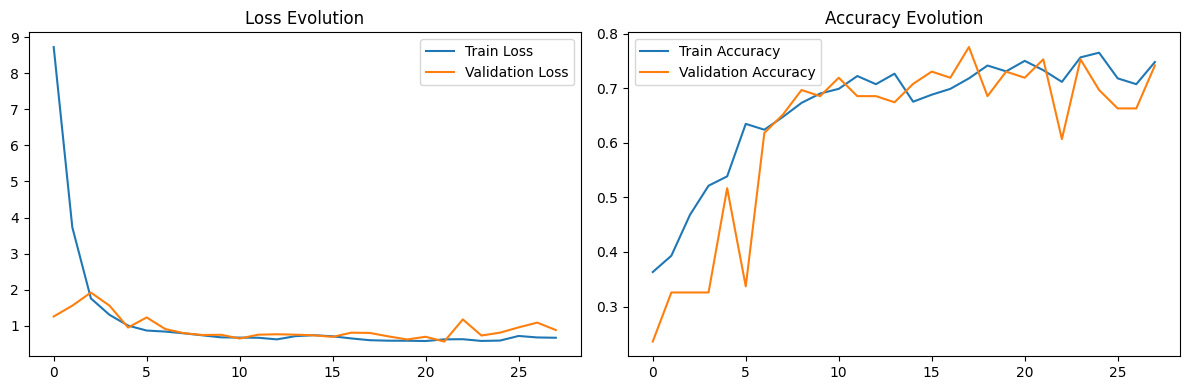

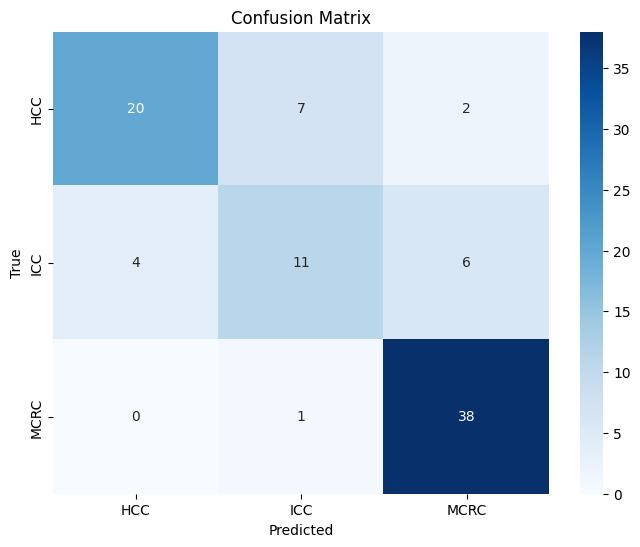

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Define an EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = -np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model):
        score = val_accuracy
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy


# Model Definition
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv0_bn = nn.BatchNorm2d(16)
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)
        
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc15 = nn.Linear(128 * 18 * 18, 4096)
        self.fc16 = nn.Linear(4096, 512)
        self.fc17 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(self.conv0_bn(self.conv0(x)))
        x = self.pool(self.conv1_bn(self.conv1(x)))
        x = self.pool(self.conv3_bn(self.conv3(x)))
        x = self.pool(self.conv5_bn(self.conv5(x)))
        # print(x.shape)  # Add this line
        x = self.flatten(x)
        x = self.fc15(x)
        x = self.fc16(x)
        return self.fc17(x)

# Create Model
model = CustomModel(num_classes=len(class_names))
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()

epochs = 40
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=10, verbose=True, path=os.path.join(data_dir, 'best_model_checkpoint.pth'))


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total_train += target.size(0)
        correct_train += predicted.eq(target).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(correct_train/total_train)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}")

    # Validation for each epoch
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total_val += target.size(0)
            correct_val += predicted.eq(target).sum().item()

    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(correct_val/total_val)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}")

    # Call early stopping
    early_stopping(val_accuracies[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last best model
model.load_state_dict(torch.load(os.path.join(data_dir, 'best_model_checkpoint.pth')))

# Save model's weights
torch.save(model.state_dict(), os.path.join(data_dir, 'model_weights.pth'))

# Save entire model
torch.save(model, os.path.join(data_dir, 'entire_model.pth'))


# Plot Training and Validation Loss & Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

# Compute Confusion Matrix
val_preds = []
val_true = []
with torch.no_grad():
    for data, target in val_loader:
        outputs = model(data)
        _, predicted = outputs.max(1)
        val_preds.extend(predicted.tolist())
        val_true.extend(target.tolist())

cm = confusion_matrix(val_true, val_preds)

# Plot Confusion Matrix and save it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(data_dir, 'confusion_matrix.png'))
plt.show()